In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import BoxStyle
from matplotlib.path import Path
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'
from scipy import stats

%matplotlib inline

In [3]:
light_response_df = pd.read_csv('../data/lightResponseData.csv')

# note, during the curve of line 1.10.19 the licor had a problem half way through and the leaf was in darkness for 5-10 mins
lr_df = light_response_df[~light_response_df['plant'].isin(['1.10.19_5'])]

# Use the first measurment at the highest light level
lr_df = lr_df[~lr_df['which_1500'].isin(['second'])]

lr_df['PhiPS2'] = pd.to_numeric(lr_df.PhiPS2, errors='coerce')
lr_df['ETR'] = pd.to_numeric(lr_df.ETR, errors='coerce')
lr_df['NPQ'] = pd.to_numeric(lr_df.NPQ, errors='coerce')
lr_df['qP'] = pd.to_numeric(lr_df.qP, errors='coerce')
lr_df['qN'] = pd.to_numeric(lr_df.qN, errors='coerce')

grouped_df = lr_df.groupby(['Q_rounded', 'plot', 'type']).agg({'A': ['mean', 'std'], 'PhiPS2': ['mean', 'std'], 
                                                               'ETR': ['mean', 'std'], 'NPQ': ['mean', 'std'], 'qP': ['mean', 'std'],
                                                               'qN': ['mean', 'std']})
grouped_df.columns = ['A_mean', 'A_std', 'PhiPS2_mean', 'PhiPS2_std', 'ETR_mean', 'ETR_std', 'NPQ_mean', 'NPQ_std', 'qP_mean', 'qP_std', 'qN_mean', 'qN_std']
grouped_df = grouped_df.reset_index()

In [4]:
class ExtendedTextBox(BoxStyle._Base):
    """
    An Extended Text Box that expands to the axes limits 
                        if set in the middle of the axes
    """

    def __init__(self, pad=0.3, width=500.):
        """
        width: 
            width of the textbox. 
            Use `ax.get_window_extent().width` 
                   to get the width of the axes.
        pad: 
            amount of padding (in vertical direction only)
        """
        self.width=(width*0.9)
        self.pad = pad
        super(ExtendedTextBox, self).__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        x0 and y0 are the lower left corner of original text box
        They are set automatically by matplotlib
        """
        # padding
        pad = mutation_size * self.pad

        # we add the padding only to the box height
        height = height + 2.*pad
        # boundary of the padded box
        y0 = y0 - pad
        y1 = y0 + height
        _x0 = x0
        x0 = _x0 +width /2. - self.width/2.
        x1 = _x0 +width /2. + self.width/2.

        cp = [(x0, y0),
              (x1, y0), (x1, y1), (x0, y1),
              (x0, y0)]

        com = [Path.MOVETO,
               Path.LINETO, Path.LINETO, Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path
    

# register the custom style
BoxStyle._style_list["ext"] = ExtendedTextBox

In [26]:
def test_for_significance(lr_df, test_parameter):
    light_levels = [1500, 1200, 1000,  800,  600,  400,  200,  100,   50,   25,    0]
    line_18 = {}
    line_19 = {}
    line_32 = {}
    line_2 = {}
    
    for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
        for conc in light_levels:
            t_test = stats.ttest_ind(lr_df[(lr_df['plot'] == line) & (lr_df['Q_rounded'] == conc) & (lr_df['type'] == 'mutant')][test_parameter].to_list(),
                                     lr_df[(lr_df['plot'] == line) & (lr_df['Q_rounded'] == conc) & (lr_df['type'] == 'wt')][test_parameter].to_list(),
                                     equal_var=True)
            if line == '1.10.18':
                line_18[conc] = t_test.pvalue
            if line == '1.10.19':
                line_19[conc] = t_test.pvalue
            if line == '1.10.32':
                line_32[conc] = t_test.pvalue
            if line == '1.12.2':
                line_2[conc] = t_test.pvalue
    
    return(line_18, line_19, line_32, line_2)

In [27]:
photo_dict = {}

A = test_for_significance(lr_df, 'A')
    
photo_dict['A_18'] = A[0]
photo_dict['A_19'] = A[1]
photo_dict['A_32'] = A[2]
photo_dict['A_2'] = A[3]

PhiPS2 = test_for_significance(lr_df, 'PhiPS2')

photo_dict['PhiPS2_18'] = PhiPS2[0]
photo_dict['PhiPS2_19'] = PhiPS2[1]
photo_dict['PhiPS2_32'] = PhiPS2[2]
photo_dict['PhiPS2_2'] = PhiPS2[3]

ETR = test_for_significance(lr_df, 'ETR')

photo_dict['ETR_18'] = ETR[0]
photo_dict['ETR_19'] = ETR[1]
photo_dict['ETR_32'] = ETR[2]
photo_dict['ETR_2'] = ETR[3]

NPQ = test_for_significance(lr_df, 'NPQ')

photo_dict['NPQ_18'] = NPQ[0]
photo_dict['NPQ_19'] = NPQ[1]
photo_dict['NPQ_32'] = NPQ[2]
photo_dict['NPQ_2'] = NPQ[3]

In [37]:
photo_dict

{'A_18': {1500: 0.8688380885832447,
  1200: 0.8266020457809861,
  1000: 0.799650726194453,
  800: 0.49997992953214887,
  600: 0.6287514329499421,
  400: 0.7233285744655584,
  200: 0.9716637420157912,
  100: 0.9275346317906381,
  50: 0.2219184408055757,
  25: 0.8476903244176404,
  0: 0.6094764384249878},
 'A_19': {1500: 0.2567936475152294,
  1200: 0.42021371112570977,
  1000: 0.5160320685784676,
  800: 0.6952058428980588,
  600: 0.594765717752821,
  400: 0.5948524950478757,
  200: 0.2972192382123824,
  100: 0.21682134475075862,
  50: 0.7670649749741457,
  25: 0.14582995971018126,
  0: 0.2998813802033199},
 'A_32': {1500: 0.04376200179030181,
  1200: 0.10528733502470518,
  1000: 0.17166133536992292,
  800: 0.3828805124446395,
  600: 0.39119539388005975,
  400: 0.4459008484989624,
  200: 0.747199240808254,
  100: 0.45097570398064357,
  50: 0.8520520851354286,
  25: 0.15775972915259798,
  0: 0.014606813821896169},
 'A_2': {1500: 0.860935693814006,
  1200: 0.9884242789486684,
  1000: 0.7943

### Light response curves

In [5]:
def plot_curve(df, y, y_std, y_label, file_name):
    # sns.plotting_context()
    sns.set(font_scale = 1.4, font="Arial")
    sns.set_style(style='ticks')

    # Choose hue colour palette
    colours = ['#000000', '#009E73']

    grid = sns.FacetGrid(df, col="plot", col_order=['1.10.18', '1.10.19', '1.10.32', '1.12.2'], hue="type", hue_order=['wt', 'mutant'],
                         palette=colours, col_wrap=2, size=4, aspect=1, hue_kws=dict(marker=["D", "o"]))

    grid.map(plt.errorbar, "Q_rounded", y, y_std, markersize=5, alpha=0.8, linewidth=0.5, linestyle='-', elinewidth=1, capsize=3, 
            markeredgecolor=None, markeredgewidth=1)


    # Adjust position abd labels of legend
    legend_ax = grid.axes.flat[3]
    handles, labels = legend_ax.get_legend_handles_labels()
    leg = plt.legend(handles[0:2],['Wild-type', 'Mutant'], bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)

    
    # Set axis labels
    grid.set_axis_labels(x_var="PFD ($\mu$mol m$^{-2}$s$^{-1}$)", y_var=y_label)

    
    # Set titles 
    # grid.set_titles("{col_name}")
    axes = grid.axes.flatten()
    axes[0].set_title("Line 1")
    axes[1].set_title("Line 2")
    axes[2].set_title("Line 3")
    axes[3].set_title("Line 4")
    
    for ax in grid.axes:
        # set the title position to the horizontal center (0.5) of the axes
        title = ax.set_title(ax.get_title(), position=(.5, 1.0), backgroundcolor="silver", color='black', 
                             size=14)
        # set the box style of the title text box to our custom box
        bb = title.get_bbox_patch()
        # use the axes' width as width of the text box
        bb.set_boxstyle("ext", pad=0.4, width=ax.get_window_extent().width )
        

#     plt.savefig(file_name, transparent=True, dpi=300, bbox_inches='tight')


/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


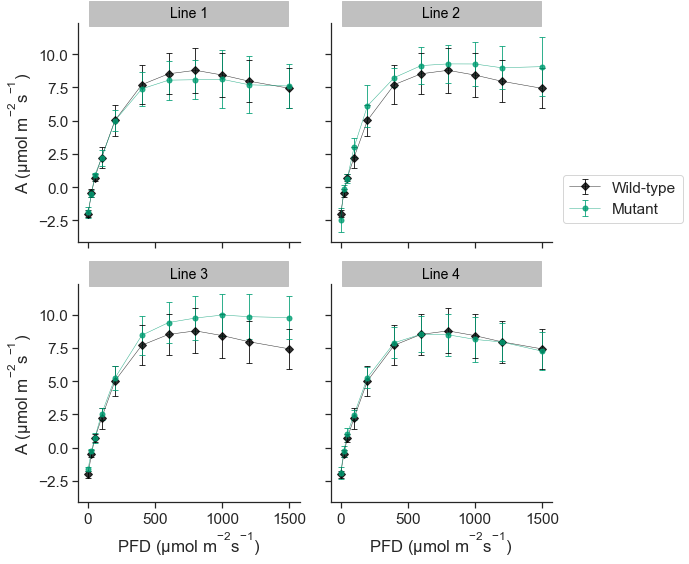

In [6]:
# Assimilation light response curve
plot_curve(grouped_df, "A_mean", "A_std", "A ($\mu$mol m$^{-2}$s$^{-1}$)", "../figures/lrCurves.pdf")

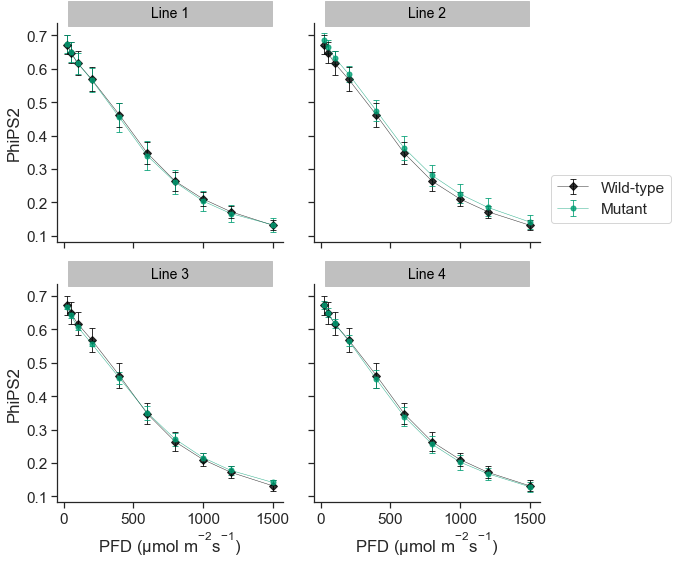

In [7]:
# PhiPS2
plot_curve(grouped_df, "PhiPS2_mean", "PhiPS2_std", "PhiPS2", "../figures/lrPhiPS2Curves.pdf")

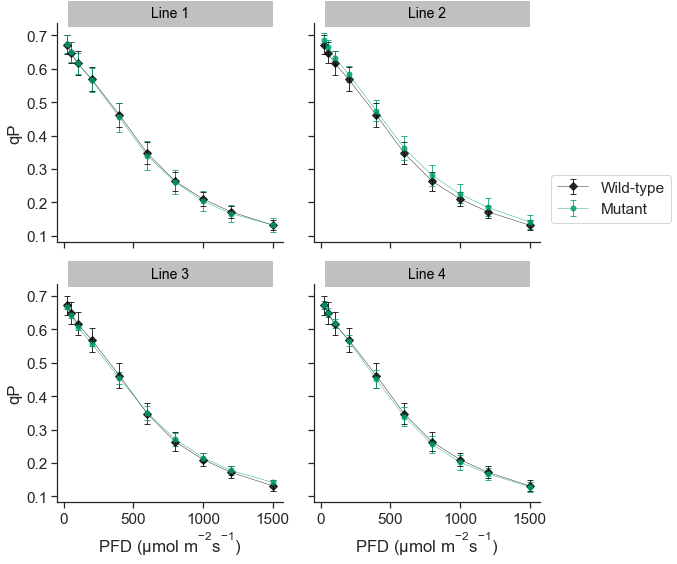

In [8]:
# qP
plot_curve(grouped_df, "qP_mean", "qP_std", "qP", "../figures/lrqpCurves.pdf")

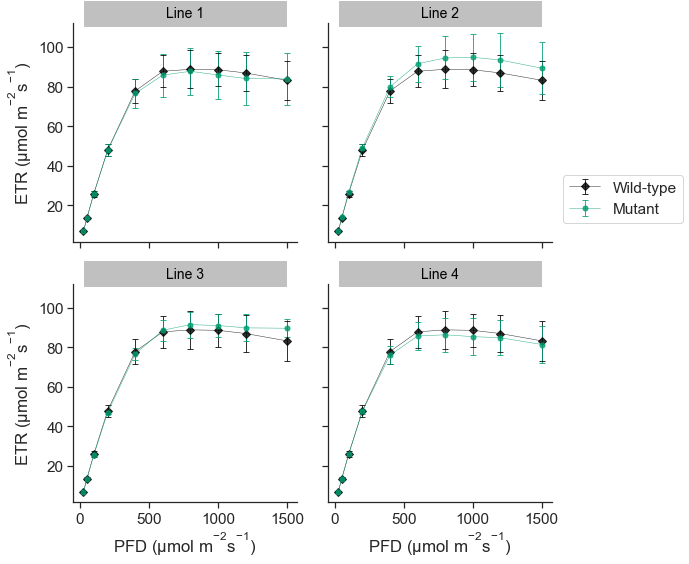

In [9]:
# ETR
plot_curve(grouped_df, "ETR_mean", "ETR_std", "ETR ($\mu$mol m$^{-2}$s$^{-1}$)", "../figures/lrETRCurves.pdf")

['wt_2' '1.10.19_1' '1.10.32_2' '1.10.18_2' '1.10.18_1' '1.12.2_2'
 '1.10.19_3' '1.12.2_3' '1.10.32_4' '1.10.18_4' '1.10.19_4' '1.12.2_5'
 'wt_4' '1.10.18_3' '1.12.2_4' 'wt_6' '1.10.18_5']


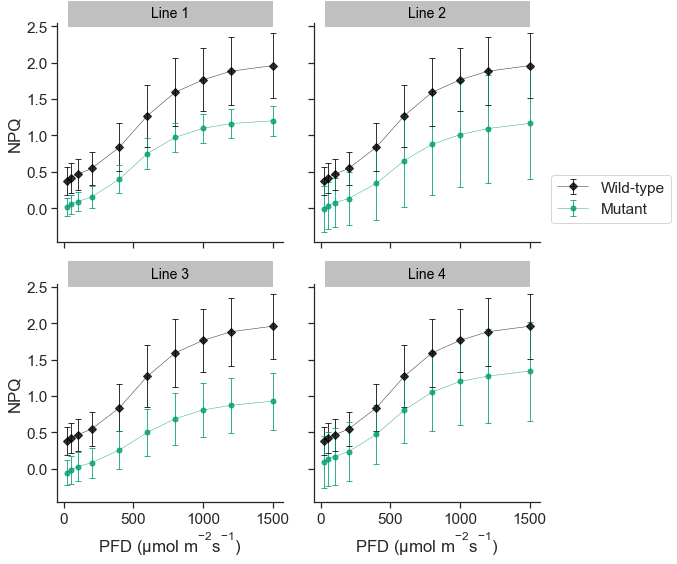

In [10]:
# NPQ

# Identify plants for which NPQ values were not successfully estimated across all data points
failed_samples = lr_df[lr_df['NPQ'] == -1]
failed_samples_list = failed_samples['plant'].unique()

# Remove those plants from the plot 
NPQ_df = lr_df[~lr_df['plant'].isin(failed_samples_list)]

# Print those plants that were included:
print(NPQ_df['plant'].unique())

# Re-group the resulting dataframe to plot NPQ vs PFD
grouped_NPQ_df = NPQ_df.groupby(['Q_rounded', 'plot', 'type']).agg({'NPQ': ['mean', 'std']})
grouped_NPQ_df.columns = ['NPQ_mean', 'NPQ_std']
grouped_NPQ_df = grouped_NPQ_df.reset_index()

plot_curve(grouped_NPQ_df, "NPQ_mean", "NPQ_std", "NPQ", "../figures/lrNPQCurves.pdf")

In [11]:
# Print failed NPQ/qN samples:
failed_samples = lr_df[lr_df['NPQ'] == -1]
failed_samples_list = failed_samples['plant'].unique()
print(failed_samples_list)

['1.10.32_1' 'wt_1' '1.12.2_1' '1.10.32_3' '1.10.32_5' 'wt_3']


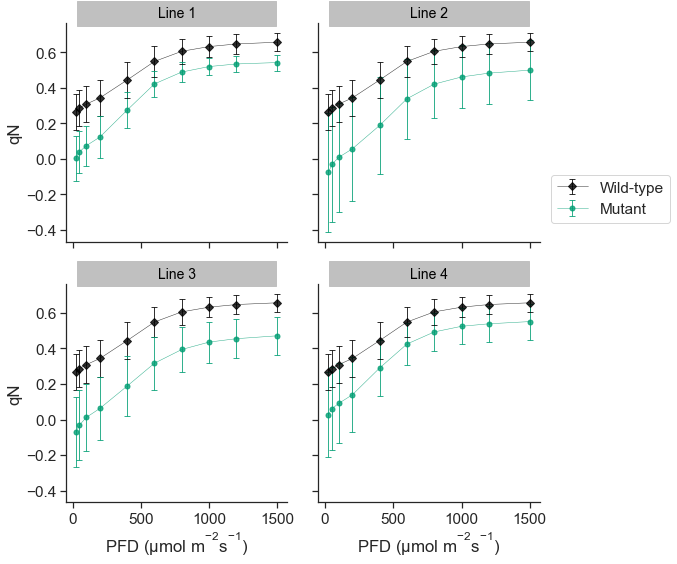

In [12]:
# qN

grouped_qN_df = grouped_df[grouped_df['Q_rounded'] != 0]

plot_curve(grouped_qN_df, "qN_mean", "qN_std", "qN", "../figures/lrqNCurves.pdf")

#### Testing for significance

In [16]:
Q = 1500

for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    t_test = stats.ttest_ind(lr_df[(lr_df['plot'] == line) & (lr_df['NPQ'] == Q) & (lr_df['type'] == 'wt')]['NPQ'].to_list(),
                             lr_df[(lr_df['plot'] == line) & (lr_df['NPQ'] == Q) & (lr_df['type'] == 'mutant')]['NPQ'].to_list(), 
                             equal_var=True)
    
    print(line)
    print(t_test.pvalue)

1.10.18
0.5820780428951131
1.10.19
0.7190364931195503
1.10.32
0.2880322847950991
1.12.2
0.916030204334549


In [58]:
Q = 25
t_test = stats.ttest_ind(lr_df[(lr_df['Q_rounded'] == Q) & (lr_df['type'] == 'wt')]['NPQ'].to_list(),
                         lr_df[(lr_df['Q_rounded'] == Q) & (lr_df['type'] == 'mutant')]['NPQ'].to_list(), 
                         equal_var=True)


print(t_test.pvalue)

0.8729612207478685


In [60]:
lr_df[lr_df['plant'] == '1.10.19_1']

,notes,plant,line,Q_copied,Q_rounded,A_copied,PhiPS2_copied,ETR_copied,NPQ_copied,qP_copied,...,Ts,Tr,CO2_%,Desiccant_%,Humidifier_%,Txchg_sp,CO2_r_sp,H2O_r_sp,SS_s,SS_r
72,NaN,1.10.19_1,1.10.19,1500.110000,1500,8.304069,0.135464,85.430510,0.486688,0.135464,...,26.6647,26.6805,14.0776,32.1947,0.000000,22.0001,400,14.3596,101.129,103.267
73,NaN,1.10.19_1,1.10.19,1200.070000,1200,8.860941,0.175392,88.506550,0.451195,0.175392,...,26.6692,26.6834,14.0741,30.7457,0.000000,23.0439,400,14.7004,101.129,103.266
74,NaN,1.10.19_1,1.10.19,999.904000,1000,9.098001,0.211996,89.156542,0.405557,0.211996,...,26.6783,26.6915,14.0774,30.7110,0.000000,23.5805,400,14.7745,101.126,103.263
75,NaN,1.10.19_1,1.10.19,800.102000,800,9.108179,0.264734,89.119815,0.319234,0.264734,...,26.6873,26.6991,14.0793,30.4543,0.000000,23.9864,400,14.8073,101.131,103.262
76,NaN,1.10.19_1,1.10.19,600.051000,600,8.873402,0.346114,87.435089,0.155575,0.346114,...,26.6985,26.7104,14.0822,30.0788,0.000000,24.4753,400,14.9405,101.128,103.261
77,NaN,1.10.19_1,1.10.19,399.827000,400,8.287670,0.457256,77.056555,-0.065701,0.457256,...,26.7144,26.7261,14.0807,28.4620,0.058215,25.0129,400,15.2485,101.127,103.257
78,NaN,1.10.19_1,1.10.19,200.109000,200,5.215168,0.563803,47.550081,-0.196097,0.563803,...,26.7415,26.7510,14.0851,26.9928,0.372824,25.6293,400,15.4927,101.118,103.251
79,NaN,1.10.19_1,1.10.19,100.161000,100,2.439754,0.612774,25.865343,-0.236773,0.612774,...,26.7686,26.7781,14.0873,25.9852,0.590711,25.8141,400,15.6485,101.114,103.248
80,NaN,1.10.19_1,1.10.19,49.836400,50,0.682009,0.646131,13.567962,-0.268282,0.646131,...,26.7958,26.8029,14.0828,25.6064,2.425890,25.8988,400,15.7954,101.112,103.242
81,NaN,1.10.19_1,1.10.19,24.973400,25,-0.430897,0.669602,7.043527,-0.296179,0.669602,...,26.8169,26.8233,14.0774,25.9695,3.968750,26.0903,400,15.7667,101.109,103.239


### Studying the dark to light transition

In [22]:
# Remove bad readings
transition_df = light_response_df[~light_response_df['plant'].isin(['1.10.19_5'])]

# Remove the first light measurment at the highest light level
transition_df = transition_df[~transition_df['which_1500'].isin(['first'])]

# Propagate NaNs for non-numerical values
transition_df['PhiPS2'] = pd.to_numeric(transition_df.PhiPS2, errors='coerce')
transition_df['ETR'] = pd.to_numeric(transition_df.ETR, errors='coerce')
transition_df['NPQ'] = pd.to_numeric(transition_df.NPQ, errors='coerce')
transition_df['qP'] = pd.to_numeric(transition_df.qP, errors='coerce')
transition_df['qN'] = pd.to_numeric(transition_df.qN, errors='coerce')

line_dict = {'wt': 'wild-type', '1.10.18': 'Line 1', '1.10.19': 'Line 2', '1.10.32': 'Line 3', '1.12.2': 'Line 4'}
transition_df['Line_name'] = transition_df['plot'].map(line_dict)

transition_df_grouped = transition_df.groupby(['Q_rounded', 'plot', 'type']).agg({'A': ['mean', 'std'], 'PhiPS2': ['mean', 'std'], 
                                                               'ETR': ['mean', 'std'], 'NPQ': ['mean', 'std'], 'qP': ['mean', 'std'],
                                                               'qN': ['mean', 'std']})

transition_df_grouped.columns = ['A_mean', 'A_std', 'PhiPS2_mean', 'PhiPS2_std', 'ETR_mean', 'ETR_std', 'NPQ_mean', 'NPQ_std', 'qP_mean', 'qP_std', 'qN_mean', 'qN_std']
transition_df_grouped = transition_df_grouped.reset_index()

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


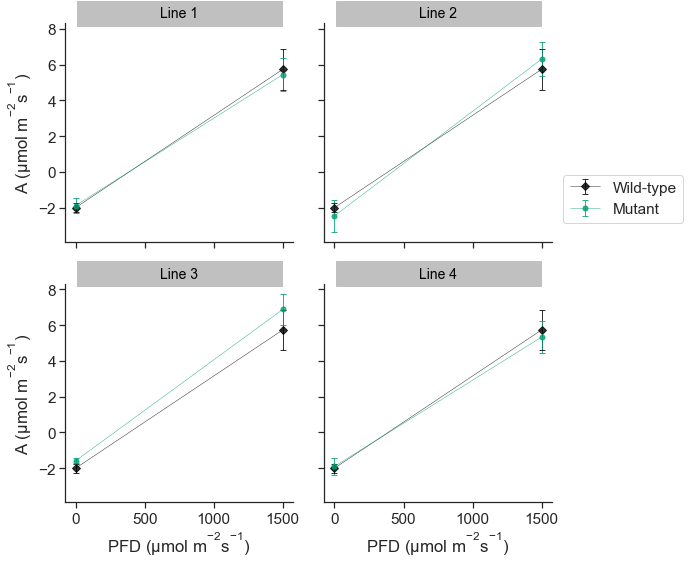

In [13]:
# Assimilation 
plot_curve(transition_df_grouped[(transition_df_grouped['Q_rounded'] == 1500) | (transition_df_grouped['Q_rounded'] == 0)], "A_mean", "A_std", "A ($\mu$mol m$^{-2}$s$^{-1}$)", "../figures/recoveryACurves.pdf")

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


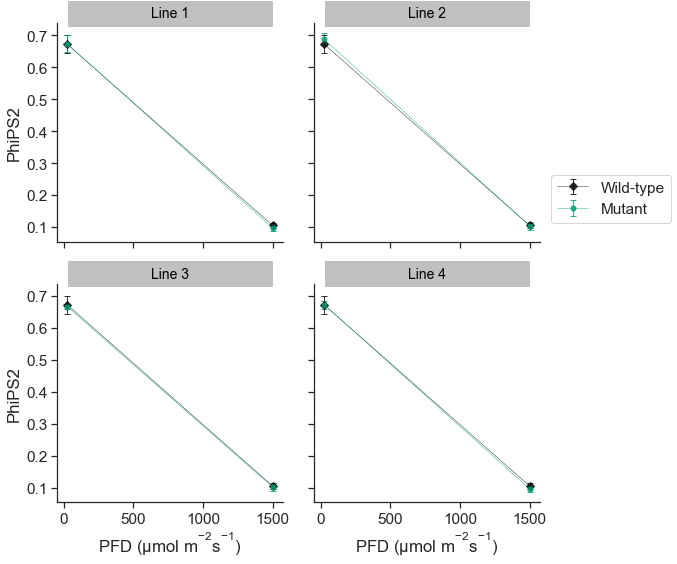

In [14]:
# PhiPS2
plot_curve(transition_df_grouped[(transition_df_grouped['Q_rounded'] == 1500) | (transition_df_grouped['Q_rounded'] == 25)], "PhiPS2_mean", "PhiPS2_std", "PhiPS2", "../figures/recoveryPhiPS2Curves.pdf")

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


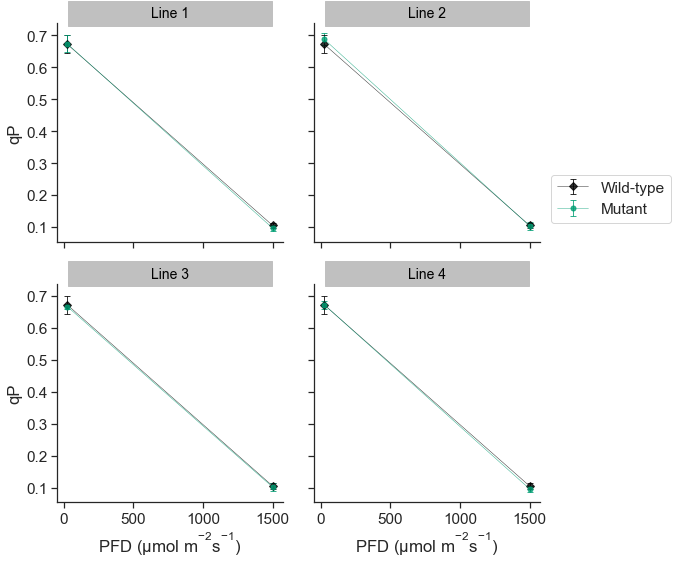

In [15]:
# qP
plot_curve(transition_df_grouped[(transition_df_grouped['Q_rounded'] == 1500) | (transition_df_grouped['Q_rounded'] == 25)], "qP_mean", "qP_std", "qP", "../figures/recoveryqpCurves.pdf")

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


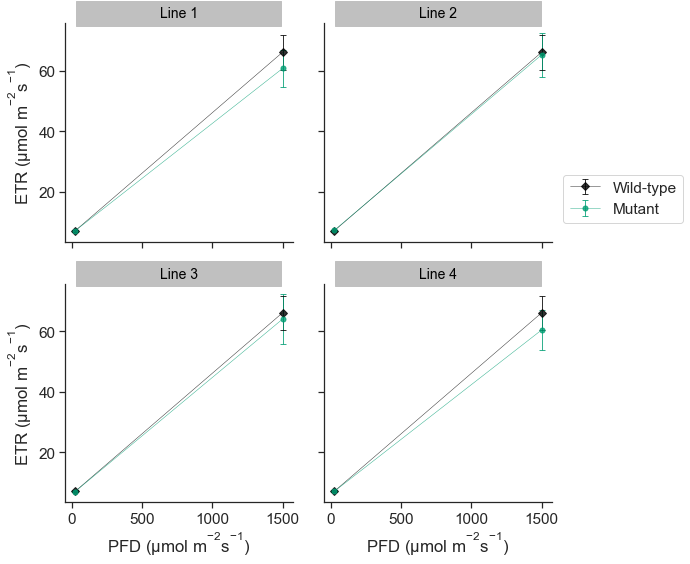

In [16]:
# ETR
plot_curve(transition_df_grouped[(transition_df_grouped['Q_rounded'] == 1500) | (transition_df_grouped['Q_rounded'] == 25)], "ETR_mean", "ETR_std", "ETR ($\mu$mol m$^{-2}$s$^{-1}$)", "../figures/recoveryETRCurves.pdf")

['wt_2' '1.10.19_1' '1.10.32_2' '1.10.18_2' '1.10.18_1' '1.12.2_2'
 '1.10.19_3' '1.12.2_3' '1.10.32_4' '1.10.18_4' '1.10.19_4' '1.12.2_5'
 'wt_4' '1.10.18_3' '1.12.2_4' 'wt_6' '1.10.18_5']


/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


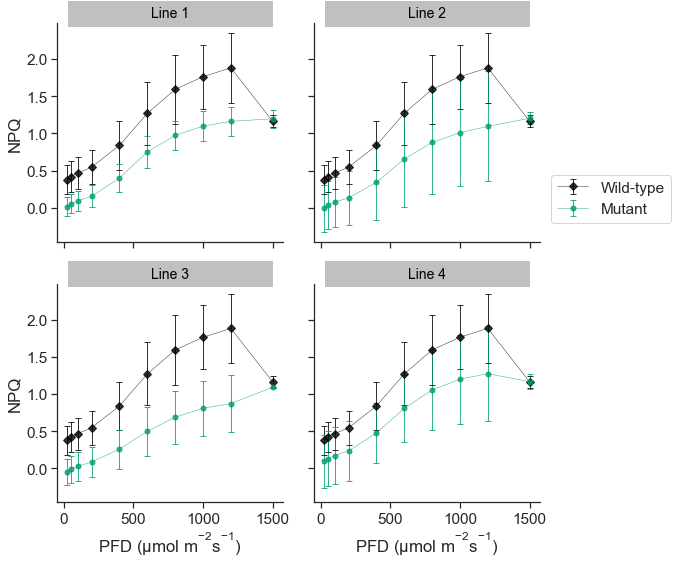

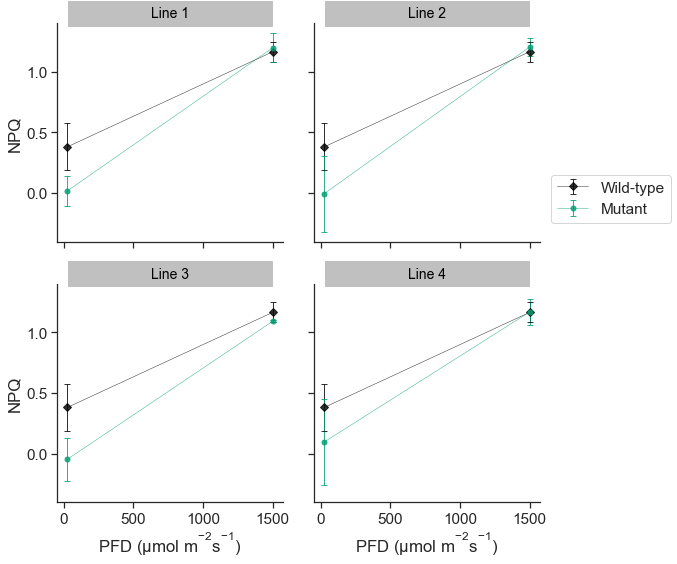

In [17]:
# NPQ

# Identify plants for which NPQ values were not successfully estimated across all data points
failed_samples = transition_df[transition_df['NPQ'] == -1]
failed_samples_list = failed_samples['plant'].unique()

# Remove those plants from the plot 
NPQ_df = transition_df[~transition_df['plant'].isin(failed_samples_list)]

# Print those plants that were included:
print(NPQ_df['plant'].unique())

# Re-group the resulting dataframe to plot NPQ vs PFD
grouped_NPQ_df = NPQ_df.groupby(['Q_rounded', 'plot', 'type']).agg({'NPQ': ['mean', 'std']})
grouped_NPQ_df.columns = ['NPQ_mean', 'NPQ_std']
grouped_NPQ_df = grouped_NPQ_df.reset_index()

# First a plot of the NPQ curve using the second measurement at 1500
plot_curve(grouped_NPQ_df, "NPQ_mean", "NPQ_std", "NPQ", "../figures/recoveryNPQCurves.pdf")

# Plot of just light at 25 and return to 1500
plot_curve(grouped_NPQ_df[(grouped_NPQ_df['Q_rounded'] == 1500) | (grouped_NPQ_df['Q_rounded'] == 25)], "NPQ_mean", "NPQ_std", "NPQ", "../figures/recoveryNPQCurves.pdf")

#### Calculation of changes in photosynthesis during the dark to light transition as a function of time

In [36]:
def plot_dark_to_light_change(trait, x_axis_name, low_light_level, file_name):
    plants = transition_df['plant'].unique()
    plants = list(plants)

    plants.remove('1.12.2_1')

    lines = []
    types = []
    time_1500 = []
    time_0 = []
    trait_1500 = []
    trait_0 = []

    for plant in plants:

        df_subset = transition_df[(transition_df['plant'] == plant) & (transition_df['plot'] == plant[:-2])]

        lines.append(plant[:-2])
        types.append(df_subset['type'].unique()[0])
        trait_1500.append(df_subset[df_subset['Q_rounded'] == 1500][trait].iloc[0])
        trait_0.append(df_subset[df_subset['Q_rounded'] == low_light_level][trait].iloc[0])
        time_1500.append(df_subset[df_subset['Q_rounded'] == 1500]['TIME'].iloc[0])
        time_0.append(df_subset[df_subset['Q_rounded'] == low_light_level]['TIME'].iloc[0])

    trait_recovery_df = pd.DataFrame(list(zip(plants, lines, types, trait_1500, trait_0, time_1500, time_0)), columns =['Plant', 'Line', 'Type', 'trait_1500', 'trait_0', 'time_1500', 'time_0']) 
    trait_recovery_df['trait_recovery'] = (trait_recovery_df['trait_1500'] - trait_recovery_df['trait_0'])/(trait_recovery_df['time_1500'] - trait_recovery_df['time_0'])
    
    line_dict = {'wt': 'wild-type', '1.10.18': 'Line 1', '1.10.19': 'Line 2', '1.10.32': 'Line 3', '1.12.2': 'Line 4'}
    trait_recovery_df['Line_name'] = trait_recovery_df['Line'].map(line_dict)
    
    if trait == 'NPQ':
        failed_samples = trait_recovery_df[trait_recovery_df['trait_0'] == -1]
        failed_samples_list = failed_samples['Plant'].unique()

        trait_recovery_df = trait_recovery_df[~trait_recovery_df['Plant'].isin(failed_samples_list)]
        print(trait_recovery_df['Plant'].unique())
        
    
    for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
        t_test = stats.ttest_ind(trait_recovery_df[trait_recovery_df['Line'] == 'wt']['trait_recovery'].to_list(), 
                    trait_recovery_df[trait_recovery_df['Line'] == line]['trait_recovery'].to_list(),
                   equal_var=True)
        print(line)
        print(t_test)
    
    colours = ['gray', '#009E73']
    ax = sns.barplot(x="Line_name", y="trait_recovery", hue="Type", data=trait_recovery_df, dodge=False, ci='sd', palette=colours, saturation=0.5,
                    order=['wild-type', 'Line 1', 'Line 2', 'Line 3', 'Line 4'])
    ax.legend_.remove()
    ax.set_ylabel(f'Change in {x_axis_name}\n (dark to light transition)')
    ax.set_xlabel('Line')
    
    plt.savefig(file_name, transparent=True, dpi=300, bbox_inches='tight')

1.10.18
Ttest_indResult(statistic=0.48068298983060326, pvalue=0.643611847606904)
1.10.19
Ttest_indResult(statistic=-0.4644665818009988, pvalue=0.658689212099483)
1.10.32
Ttest_indResult(statistic=0.40673274316048275, pvalue=0.6948684589267369)
1.12.2
Ttest_indResult(statistic=-0.18410755007347496, pvalue=0.8591489756701849)


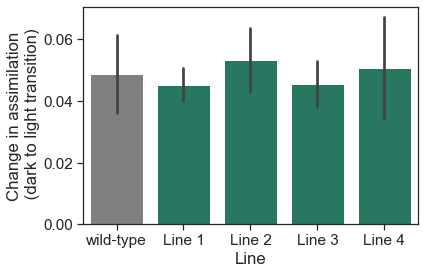

In [37]:
plot_dark_to_light_change('A', 'assimilation', 0, '../figures/dark_to_light_assimilation_change.pdf')

1.10.18
Ttest_indResult(statistic=-0.21106227794766283, pvalue=0.8381158680143208)
1.10.19
Ttest_indResult(statistic=-0.3904665021452913, pvalue=0.709677973422759)
1.10.32
Ttest_indResult(statistic=-1.2774653552406532, pvalue=0.2372612575564377)
1.12.2
Ttest_indResult(statistic=0.2897923130447531, pvalue=0.7803710197149729)


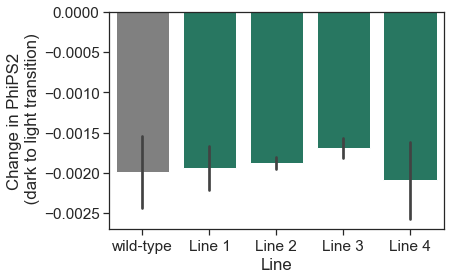

In [38]:
plot_dark_to_light_change('PhiPS2', 'PhiPS2', 25, '../figures/dark_to_light_phips2_change.pdf')

1.10.18
Ttest_indResult(statistic=1.070498819468117, pvalue=0.315625832659429)
1.10.19
Ttest_indResult(statistic=0.5928577106756494, pvalue=0.574925303722255)
1.10.32
Ttest_indResult(statistic=1.2505339511415876, pvalue=0.24644090408645572)
1.12.2
Ttest_indResult(statistic=0.42896176762865534, pvalue=0.6808433635531622)


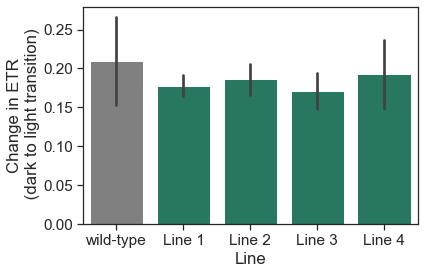

In [39]:
plot_dark_to_light_change('ETR', 'ETR', 25, '../figures/dark_to_light_ETR_change.pdf')

['wt_2' '1.10.19_1' '1.10.32_2' '1.10.18_2' '1.10.18_1' '1.12.2_2'
 '1.10.19_3' '1.12.2_3' '1.10.32_4' '1.10.18_4' '1.10.19_4' '1.12.2_5'
 'wt_4' '1.10.18_3' '1.12.2_4' 'wt_6' '1.10.18_5']
1.10.18
Ttest_indResult(statistic=-0.9084910715172643, pvalue=0.39863905791696164)
1.10.19
Ttest_indResult(statistic=-0.6777826090780394, pvalue=0.5350900911603722)
1.10.32
Ttest_indResult(statistic=-0.30361364045488476, pvalue=0.7812611374908291)
1.12.2
Ttest_indResult(statistic=-0.5791504303962449, pvalue=0.5875989753568689)


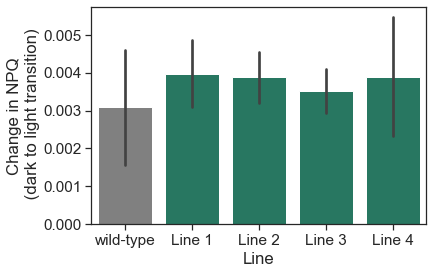

In [40]:
plot_dark_to_light_change('NPQ', 'NPQ', 25, '../figures/dark_to_light_NPQ_change.pdf')